# Semi-supervised Variational Autoencoder
Code for re-creating results included in Deep Learning Fall 2017 course report by Niels Jeppesen (niejep/s082927).

VAE implementation can be found in `autoencoder.py`.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from keras.layers import Dense, BatchNormalization, Activation, Dropout, Lambda, Input, Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D, Reshape, Flatten
from keras.datasets import mnist
from keras.backend import clear_session
from keras.utils import to_categorical

from autoencoder import SemiSupervisedClassifier

Using TensorFlow backend.


Initialize some variables we need.

In [2]:
# Set True to train the models.
TRAIN = False
# Set True to load last weights for each model from default folder.
LOAD_LAST_WEIGHTS = True

input_dir = r'output'

training_epochs = 20
starting_epoch = 0

batch_size = 50

Load MNIST data.

In [3]:
shape = (28,28,1)
size = np.array(shape).prod()
input_dim = (size,)
batch_size = 50
num_classes = 10

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.
x_test = x_test / 255.

train_size = 60000
x_train = x_train.reshape((x_train.shape[0],) + input_dim)[:train_size]
x_test = x_test.reshape((x_test.shape[0],) + input_dim)
y_train = to_categorical(y_train)[:train_size]
y_test = to_categorical(y_test)
# TODO Filter out negative classes (only A-scan classes).

# Get labelled sets.
num_labels = 100
x_train, x_train_label, y_train, y_train_label = train_test_split(x_train, y_train, stratify=y_train, test_size=num_labels/x_train.shape[0], random_state=42)
x_test_label = x_test
y_test_label = y_test

# Repeat data to have the same length as training data.
repeats = len(x_train) // len(x_train_label) + 1
x_train_label = np.repeat(x_train_label, repeats, axis=0)[:len(x_train)]
np.random.seed(42)
np.random.shuffle(x_train_label)
np.random.seed(123)
np.random.shuffle(x_test)
y_train_label = np.repeat(y_train_label, repeats, axis=0)[:len(x_train)]
np.random.seed(42)
np.random.shuffle(y_train_label)
np.random.seed(123)
np.random.shuffle(y_test)

factor_labels = x_train.shape[0] / num_labels

Functions for creating layers.

In [4]:
def get_dense_layers(input_dim, intermediate_dim=500, activation='relu'):
    #if TRAIN:
        #clear_session()

    encoder_layers = [
        Dense(intermediate_dim),
        #BatchNormalization(),
        Activation(activation),
        Dense(intermediate_dim),
        #BatchNormalization(),
        Activation(activation),
    ]

    decoder_layers = [
        Dense(intermediate_dim),
        #BatchNormalization(),
        Activation(activation),
        Dense(intermediate_dim),
        #BatchNormalization(),
        Activation(activation),
        Dense(input_dim[0], activation='sigmoid', name='decoder_output'),
    ]

    return (encoder_layers, decoder_layers)

def get_conv_dense_layers(input_dim, conv_layers, filters, intermediate_layers, intermediate_dim, pool_size=(2, 2), activation='relu'):
    #if TRAIN:
        #clear_session()

    padding = 'same'

    channels = input_dim[2]
    
    # Calculate upsample shape.
    upsample_shape = (input_dim[0] // (pool_size[0] ** (conv_layers*2)), input_dim[1] // (pool_size[1] ** (conv_layers*2)), filters * (conv_layers))

    encoder_layers = [[
        Conv2D(filters * i, kernel_size=(3, 3), padding='same'),
        #BatchNormalization(),
        Activation(activation),
        Conv2D(filters * i, kernel_size=(3, 3), strides=(2, 2), padding=padding),
        #BatchNormalization(),
        Activation(activation),
        MaxPooling2D(pool_size=pool_size)
    ] for i in range(1, conv_layers + 1)]

    encoder_layers += [
        Flatten()
    ]

    encoder_layers += [[
        Dense(intermediate_dim),
        #BatchNormalization(),
        Activation(activation),
    ] for _ in range(intermediate_layers)]

    decoder_layers = [[
        Dense(intermediate_dim),
        #BatchNormalization(),
        Activation(activation),
    ] for _ in range(intermediate_layers)]

    decoder_layers += [
        Dense(np.product(upsample_shape)),
        #BatchNormalization(),
        Activation(activation),
        Reshape(upsample_shape)
    ]

    decoder_layers += [[
        UpSampling2D(pool_size),
        Conv2DTranspose(filters * i, kernel_size=(3, 3), strides=(2, 2), padding='same'),
        #BatchNormalization(),
        Activation(activation),
        Conv2DTranspose(filters * i, kernel_size=(3, 3), padding=padding),
        #BatchNormalization(),
        Activation(activation),
    ] for i in range(conv_layers, 0, -1)]

    decoder_layers += [
        Conv2DTranspose(channels, kernel_size=(3, 3), activation='sigmoid', padding=padding, name='decoder_output')
    ]

    return (encoder_layers, decoder_layers)

def get_conv_layers(input_dim, conv_layers, filters, pool_size=(2, 2), activation='relu'):
    #if TRAIN:
        #clear_session()

    padding = 'valid'

    encoder_layers = [[
        Conv2D(filters * i, kernel_size=(3, 3), padding='same'),
        #BatchNormalization(),
        Activation(activation),
        Conv2D(filters * i, kernel_size=(3, 3), strides=(2, 2), padding=padding),
        #BatchNormalization(),
        Activation(activation),
        MaxPooling2D(pool_size=pool_size)
    ] for i in range(1, conv_layers + 1)]

    decoder_layers = [[
        UpSampling2D(pool_size),
        Conv2DTranspose(filters * i, kernel_size=(3, 3), strides=(2, 2), padding='same'),
        #BatchNormalization(),
        Activation(activation),
        Conv2DTranspose(filters * i, kernel_size=(3, 3), padding=padding),
        #BatchNormalization(),
        Activation(activation),
    ] for i in range(conv_layers, 0, -1)]

    decoder_layers += [
        Conv2DTranspose(input_dim[-1], kernel_size=(3, 3), activation='sigmoid', padding=padding, name='decoder_output')
    ]

    return (encoder_layers, decoder_layers)

def get_classifier_layers(filters, intermediate_dim, num_classes=10, activation='relu', reshape=(28,28,1)):
    classifier_layers = [
        Reshape(reshape),
        Conv2D(filters, kernel_size=(3,3), strides=(1, 1), padding='valid'),
        # BatchNormalization(),
        Activation(activation),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(filters, kernel_size=(3,3), strides=(1, 1), padding='valid'),
        # BatchNormalization(),
        Activation(activation),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(intermediate_dim),
        # BatchNormalization(),
        Activation(activation),
        Dense(num_classes, activation='softmax', name='classifier_output')
    ]

    return classifier_layers


Functions for creating the VAEs.

In [5]:
def create_dense_vae(z_dim):
    input_dim = (size,)
    
    encoder_layers, decoder_layers = get_dense_layers(input_dim)
    classifier_layers = get_classifier_layers(filters=30, intermediate_dim=500)

    autoencoder = SemiSupervisedClassifier(input_dim, encoder_layers, decoder_layers, 
                                           classifier_layers, num_classes=10, 
                                           factor_labels=factor_labels, z_dim=z_dim, 
                                           model_name='MNIST_Dense_SSVAE_z' + str(z_dim))
    
    return autoencoder

def create_conv_dense_vae(z_dim):
    input_dim = shape
    
    encoder_layers, decoder_layers = get_conv_dense_layers(input_dim, conv_layers=1, filters=30, 
                                                           intermediate_layers=1, intermediate_dim=500)
    classifier_layers = get_classifier_layers(filters=30, intermediate_dim=500)

    autoencoder = SemiSupervisedClassifier(input_dim, encoder_layers, decoder_layers, 
                                           classifier_layers, num_classes=10, 
                                           factor_labels=factor_labels, z_dim=z_dim, 
                                           model_name='MNIST_Conv_Dense_SSVAE_z' + str(z_dim))
    
    return autoencoder
    

Create function to use for loading weights and training.

In [6]:
def fit(model, x_train, x_train_label, y_train_label, x_test, x_test_label, y_test_label, batch_size=50):

    x_train = x_train.reshape(x_train.shape[:1] + model.input_shape[0][1:])
    x_test = x_test.reshape(x_test.shape[:1] + model.input_shape[0][1:])
    x_train_label = x_train_label.reshape(x_train_label.shape[:1] + model.input_shape[0][1:])
    x_test_label = x_test_label.reshape(x_test_label.shape[:1] + model.input_shape[0][1:])
    
    if LOAD_LAST_WEIGHTS:
        glob_path = ('\\'.join(model.checkpoint_callback.filepath
                                           .split('\\')[:2]) + '\\**\\*weights.*.hdf5').replace('output', input_dir)
        weight_paths = glob.glob(glob_path, recursive=True)
        print('Looking for weights in "%s".' % (glob_path))

        if weight_paths:
            newest_weights = weight_paths[-1]
            
            print('Loading weights from "%s".' % (newest_weights))
            
            model.load_weights(newest_weights)

            weights.append(newest_weights)

    if not TRAIN:
        return

    # If 0, not histogram data is saved. Change to save Tensorboard histograms.
    model.tensorboard_callback.histogram_freq = 0
    
    # Don't write graph because we have all graphs build at once and it's a mess.
    model.tensorboard_callback.write_graph = False
    
    # Print summaries to console.
    model.encoder.summary()
    model.decoder.summary()
    model.summary()

    # Save summary.
    model.save_summary([model.encoder, model.decoder, model.classifier])

    history.append(model.fit(
        [x_train, x_train_label, y_train_label], 
        x_train,
        batch_size=batch_size, 
        epochs=starting_epoch + training_epochs,
        initial_epoch=starting_epoch,
        validation_data=([x_test, x_test_label, y_test_label], x_test),
        callbacks=[model.tensorboard_callback, model.checkpoint_callback]))

### Instantiate models

In [7]:
# Clear TF graph.
clear_session()

models = []

for z_dim in [2, 20, 100]:
    dense = create_dense_vae(z_dim)
    conv_dense = create_conv_dense_vae(z_dim)
    
    models.append(dense)
    models.append(conv_dense)    

## Load and/or train models
Fit models by training and/or loading weights.
To monitor training with Tensorboard type `tensorboard --logdir=output` in console while in the repository root folder.

In [8]:
weights = []
history = []

for model in models:
    fit(model, x_train, x_train_label, y_train_label, x_test, x_test_label, y_test_label, batch_size)

Looking for weights in "output\MNIST_Dense_SSVAE_z2\**\*weights.*.hdf5".
Loading weights from "output\MNIST_Dense_SSVAE_z2\20180103-154413\models\20180103-154413.weights.00019-365.38.hdf5".
Looking for weights in "output\MNIST_Conv_Dense_SSVAE_z2\**\*weights.*.hdf5".
Loading weights from "output\MNIST_Conv_Dense_SSVAE_z2\20180103-154414\models\20180103-154414.weights.00019-360.90.hdf5".
Looking for weights in "output\MNIST_Dense_SSVAE_z20\**\*weights.*.hdf5".
Loading weights from "output\MNIST_Dense_SSVAE_z20\20180103-154416\models\20180103-154416.weights.00019-263.11.hdf5".
Looking for weights in "output\MNIST_Conv_Dense_SSVAE_z20\**\*weights.*.hdf5".
Loading weights from "output\MNIST_Conv_Dense_SSVAE_z20\20180103-154417\models\20180103-154417.weights.00019-243.45.hdf5".
Looking for weights in "output\MNIST_Dense_SSVAE_z100\**\*weights.*.hdf5".
Loading weights from "output\MNIST_Dense_SSVAE_z100\20180103-154419\models\20180103-154419.weights.00019-258.48.hdf5".
Looking for weights in

### Training plots
We can load the training data from the Tensorflow summaries and plot them.

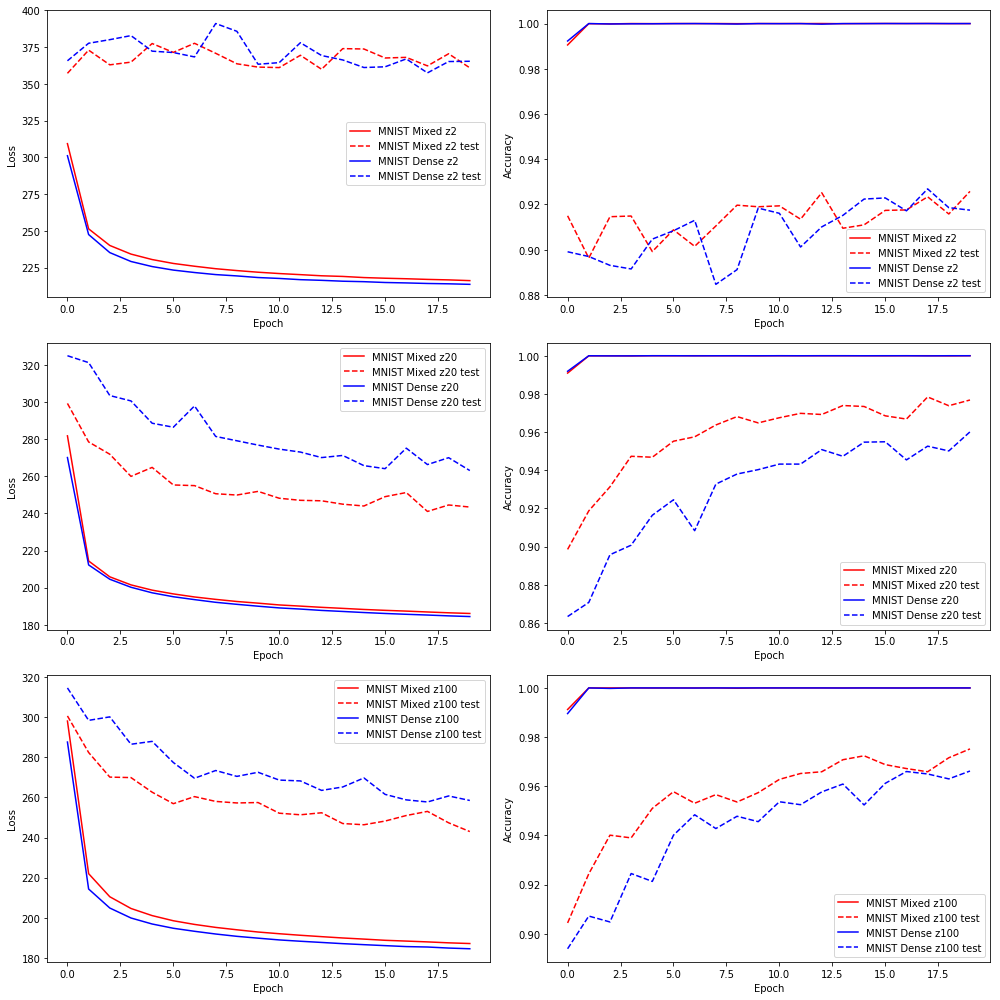

In [9]:
root_paths = [
    r'MNIST*SSVAE*z2\**\events.out.tfevents*',
    r'MNIST*SSVAE*z20\**\events.out.tfevents*',
    r'MNIST*SSVAE*z100\**\events.out.tfevents*',
]

plt.figure(figsize=(14,14))
n = 0

tags = ['loss', 'val_loss', 'acc', 'val_acc']

for root_path in root_paths:
    root_path = os.path.join(input_dir, root_path)
    
    paths = glob.glob(root_path, recursive=True)
    model_names = []
    ax_l = plt.subplot(len(root_paths), 2, n*2 + 1)
    ax_a = plt.subplot(len(root_paths), 2, n*2 + 2)

    for path in paths:
        model = path.split('output')[1].split('\\')[1]
        data = {}
        

        for e in tf.train.summary_iterator(path):
            for v in e.summary.value:
                if v.tag in tags:
                    if v.tag not in data:
                        data[v.tag] = []

                    data[v.tag].append(v.simple_value)

        color = 'r' if 'Conv_Dense' in model else 'b' if 'Dense' in model else 'g'

        ax_l.plot(data['loss'], color + '-')
        ax_l.plot(data['val_loss'], color + '--')
        ax_a.plot(data['acc'], color + '-')
        ax_a.plot(data['val_acc'], color + '--')
        model_names.append(model + '')
        model_names.append(model + '_val')

    for i in range(len(model_names)):
        model_names[i] = model_names[i].replace('Conv_Dense_SSVAE', 'Mixed')
        model_names[i] = model_names[i].replace('Dense_SSVAE', 'Dense')

        model_names[i] = model_names[i].replace('_', ' ')
        model_names[i] = model_names[i].replace('val', 'test')
        model_names[i] = model_names[i].replace('UT Conv z2', 'UT Conv z3x2')
        model_names[i] = model_names[i].replace('UT Conv z100', 'UT Conv z3x100')
        
    ax_l.legend(model_names)
    ax_l.set_xlabel('Epoch')
    ax_l.set_ylabel('Loss')
    
    ax_a.legend(model_names)
    ax_a.set_xlabel('Epoch')
    ax_a.set_ylabel('Accuracy')

    # if 'MNIST' in model_names[0]:
    #     plt.axis([0,20,-115,-95])
    # else:
    #     plt.axis([0,20,-8450,-8380])

    #tickpos = range(0, 20, 5)
    #ax_l.set_xticks(tickpos)
    #ax_a.set_xticks(tickpos)

    n = n + 1
    
plt.tight_layout()
plt.show()

## Misclassified and anomalies
For each model, let's have a look at 100 of the misclassified samples from the test set, as well as the 100 least certain classifications (ones with the lowest softmax probability). Digits in red are uncertain predictions which were also misclassified.

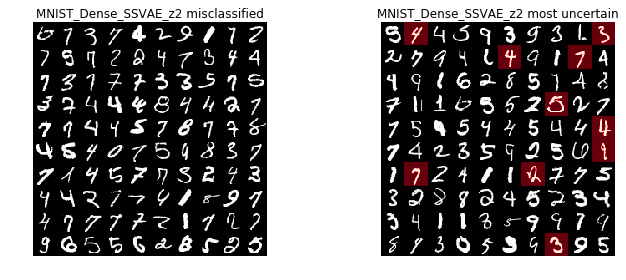

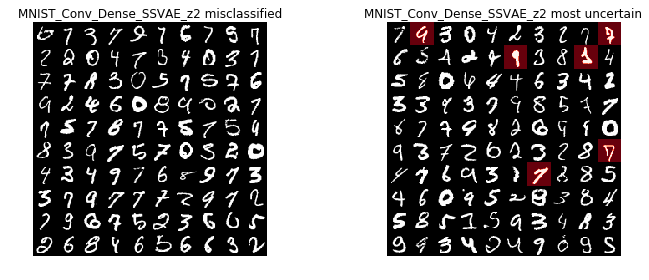

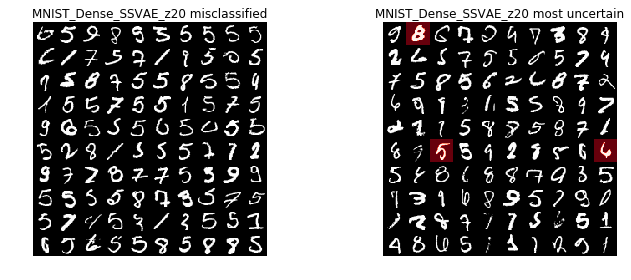

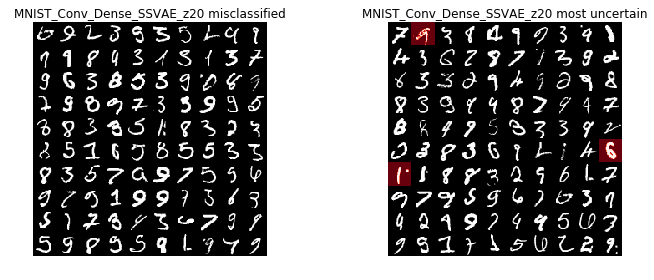

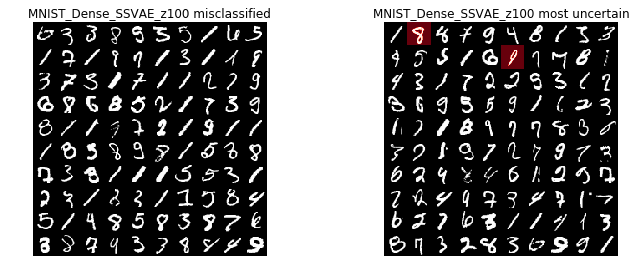

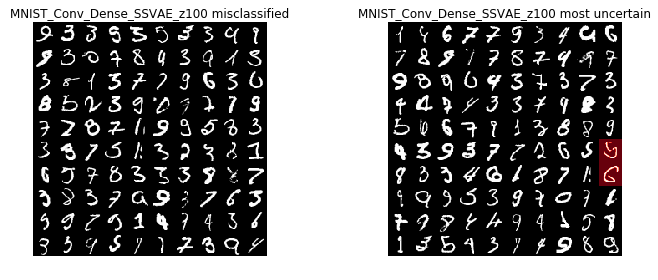

In [10]:
for model in models:

    x_test = x_test.reshape(x_test.shape[:1] + model.input_shape[0][1:])
    x_test_label = x_test_label.reshape(x_test_label.shape[:1] + model.input_shape[0][1:])

    y_test_pred = model.classifier.predict(x_test, batch_size=50)
    y_test_pred_std = np.argmax(y_test_pred, axis=1)
    y_test_std = np.argmax(y_test, axis=1)

    wrong_pred_img = np.zeros((10, 10, 28, 28))
    count = 0
    for i, yp in enumerate(y_test_pred_std):
        if count > 99:
            break

        if y_test_std[i] - yp != 0:

            # print('%d->%d      %s' % (y_test_std[i], yp, y_test_pred[i]))

            r = count // 10
            c = count % 10
            count = count + 1

            wrong_pred_img[r,c] = x_test[i].reshape(shape[:-1])
            # top_losses_pred_img[r,c] = predicted[i].reshape(shape[:-1])

    y_uncertain = np.amax(y_test_pred, axis=1).argsort()[:100][::-1]

    uncertain_pred_img = np.zeros((10, 10, 28, 28, 4))
    reds = plt.cm.get_cmap('Reds_r')
    greens = plt.cm.get_cmap('Greens_r')
    gray = plt.cm.get_cmap('gray')

    for i, idx in enumerate(y_uncertain):
        r = i // 10
        c = i % 10

        if y_test_pred_std[i] - y_test_std[i] != 0:
            img = reds(x_test[idx].reshape(shape[:-1]))
        else:
            img = gray(x_test[idx].reshape(shape[:-1]))

        uncertain_pred_img[r,c] = img

    wrong_pred_img = np.concatenate(np.concatenate(wrong_pred_img, axis=1), axis=1)
    uncertain_pred_img = np.concatenate(np.concatenate(uncertain_pred_img, axis=1), axis=1)
    # top_losses_pred_img = np.concatenate(np.concatenate(top_losses_pred_img, axis=1), axis=1)

    plt.figure(figsize=(10,4))
    ax = plt.subplot(1, 2, 1)
    ax.axis('off')
    ax.set_title(model.name + ' misclassified')
    ax.imshow(wrong_pred_img, cmap='gray')

    ax = plt.subplot(1, 2, 2)
    ax.axis('off')
    ax.set_title(model.name + ' most uncertain')
    ax.imshow(uncertain_pred_img, cmap='gray')

    # ax = plt.subplot(1, 3, 2)
    # ax.axis('off')
    # ax.imshow(top_losses_pred_img, cmap='gray')

    # ax = plt.subplot(1, 3, 3)
    # ax.set_xticks(range(10))
    # ax.hist(np.take(y_test, top_losses), bins=range(11), align='left')

    plt.tight_layout()
    plt.show()